# Tuberculosis 

## Importing Libraries

In [22]:

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import shutil

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score

import glob
import random
import re

import random
from IPython.display import Image
import matplotlib.cm as cm


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Prepare data and build a CNN & Transfer Learning model

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
import os
import pandas as pd

DATASET_PATH = r"D:\Nivaran_2.0\Tuberculosis\TB_Chest_Radiography_Database"

# Get the list of image files from the Normal and Tuberculosis directories
normal_images = os.listdir(os.path.join(DATASET_PATH, "Normal"))
tb_images = os.listdir(os.path.join(DATASET_PATH, "Tuberculosis"))

# Check the list of images
print("Number of Normal images:", len(normal_images))
print("Number of Tuberculosis images:", len(tb_images))

print("\nFirst 5 images of Normal:", normal_images[:5])
print("First 5 images of Tuberculosis:", tb_images[:5])


Number of Normal images: 3500
Number of Tuberculosis images: 3194

First 5 images of Normal: ['Normal-1.png', 'Normal-10.png', 'Normal-100.png', 'Normal-1000.png', 'Normal-1001.png']
First 5 images of Tuberculosis: ['TB.1.jpg', 'TB.10.jpg', 'TB.100.jpg', 'TB.1000.jpg', 'TB.1001.jpg']


## Create a DataFrame containing image information.

In [3]:
# Create DataFrame for Normal images
df_normal = pd.DataFrame({
    "Image": normal_images,
    "Tuberculosis": "0"  # Assign label 0 for normal images
})

# Create DataFrame for Tuberculosis images
df_tb = pd.DataFrame({
    "Image": tb_images,
    "Tuberculosis": "1"  # Assign label 1 for tuberculosis images
})

# Merge both DataFrames into one
df = pd.concat([df_normal, df_tb], ignore_index=True)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the dataset
print(df.head())


                  Image Tuberculosis
0            TB.946.jpg            1
1       Normal-1970.png            0
2  Tuberculosis-498.png            1
3            TB.860.jpg            1
4  Tuberculosis-585.png            1


In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset (80% train, 10% validation, 10% test)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["Tuberculosis"], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df["Tuberculosis"], random_state=42)

# Check the number of images in each set
print(f"Train: {len(train_df)} images")
print(f"Validation: {len(val_df)} images")
print(f"Test: {len(test_df)} images")


Train: 5355 images
Validation: 669 images
Test: 670 images


In [5]:
# Update the image paths based on the label
train_df["Image"] = train_df.apply(lambda x: f"Normal/{x['Image']}" if x["Tuberculosis"] == "0" else f"Tuberculosis/{x['Image']}", axis=1)
val_df["Image"] = val_df.apply(lambda x: f"Normal/{x['Image']}" if x["Tuberculosis"] == "0" else f"Tuberculosis/{x['Image']}", axis=1)
test_df["Image"] = test_df.apply(lambda x: f"Normal/{x['Image']}" if x["Tuberculosis"] == "0" else f"Tuberculosis/{x['Image']}", axis=1)

# Check the first 5 rows to verify
print(train_df.head())


                                  Image Tuberculosis
3718  Tuberculosis/Tuberculosis-519.png            1
1620              Normal/Normal-554.png            0
3233             Normal/Normal-2604.png            0
5701            Tuberculosis/TB.463.jpg            1
3322  Tuberculosis/Tuberculosis-468.png            1


## Load data using ImageDataGenerator

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Define ImageDataGenerator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test generators (without augmentation)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load training data
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=DATASET_PATH,
    x_col="Image",
    y_col="Tuberculosis",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Load validation data
val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    directory=DATASET_PATH,
    x_col="Image",
    y_col="Tuberculosis",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Load test data
test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    directory=DATASET_PATH,
    x_col="Image",
    y_col="Tuberculosis",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False  # Ensure consistency in test results
)

# Check the data loading process
print(f"Training batches: {len(train_generator)}")
print(f"Validation batches: {len(val_generator)}")
print(f"Test batches: {len(test_generator)}")

Found 5355 validated image filenames belonging to 2 classes.
Found 669 validated image filenames belonging to 2 classes.
Found 670 validated image filenames belonging to 2 classes.
Training batches: 168
Validation batches: 21
Test batches: 21


## Check if the data has been loaded correctly

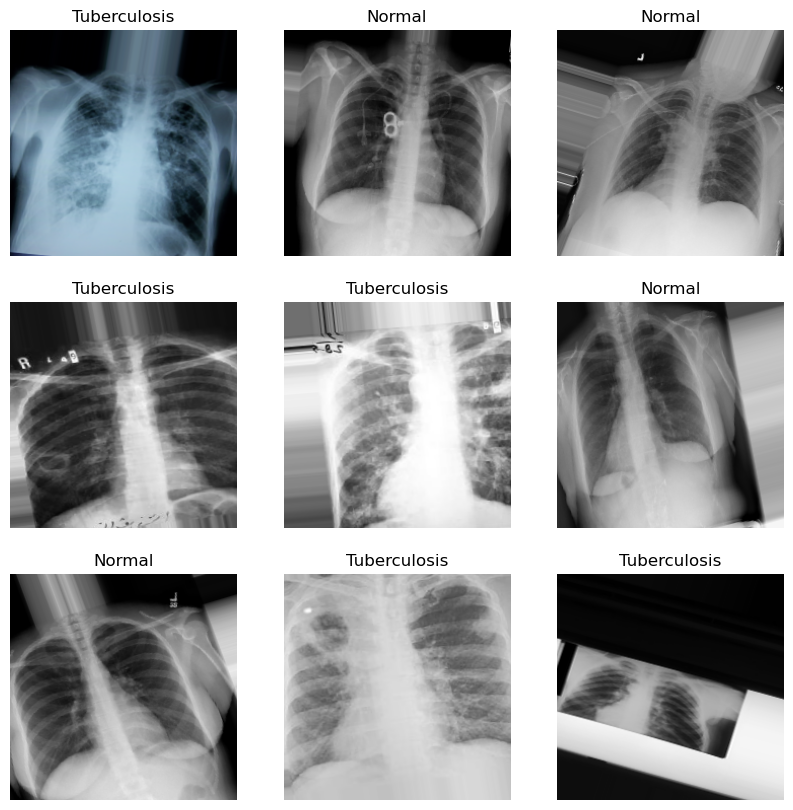

In [7]:

import matplotlib.pyplot as plt

# Get a batch of images
images, labels = next(train_generator)

# Display images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title("Tuberculosis" if labels[i] == 1 else "Normal")
    plt.axis("off")
plt.show()


## Train and Evaluate the Model

### Build a Shallow-CNN Model for Tuberculosis Detection

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Initialize the Shallow-CNN model
shallow_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Reduce overfitting
    Dense(1, activation='sigmoid')  # 1 neuron output with sigmoid activation
])

# Compile the model
shallow_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
shallow_cnn.summary()


c:\Users\rohan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,929 (84.86 MB)

 Trainable params: 22,244,929 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

### Configure Callbacks in Keras

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1)
]
'''
EarlyStopping : 
Monitors "val_loss" (validation loss).
Stops training if validation loss does not improve for 5 consecutive epochs (patience=5).
Restores the best model weights before stopping (restore_best_weights=True), ensuring the final model is the best one observed during training.

ReduceLROnPlateau : 
Monitors "val_loss" (validation loss).
If val_loss does not improve for 3 consecutive epochs (patience=3), it reduces the learning rate.
The learning rate is reduced by a factor of 0.2 (factor=0.2), meaning it becomes 20% of its current value.
verbose=1 prints updates when the learning rate changes.'''

'\nEarlyStopping : \nMonitors "val_loss" (validation loss).\nStops training if validation loss does not improve for 5 consecutive epochs (patience=5).\nRestores the best model weights before stopping (restore_best_weights=True), ensuring the final model is the best one observed during training.\n\nReduceLROnPlateau : \nMonitors "val_loss" (validation loss).\nIf val_loss does not improve for 3 consecutive epochs (patience=3), it reduces the learning rate.\nThe learning rate is reduced by a factor of 0.2 (factor=0.2), meaning it becomes 20% of its current value.\nverbose=1 prints updates when the learning rate changes.'

### Train the Model (Shallow-CNN)

In [10]:
history = shallow_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2, # Train for a maximum of 20 epochs
    callbacks=callbacks
)

c:\Users\rohan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
168/168 ━━━━━━━━━━━━━━━━━━━━ 606s 4s/step - accuracy: 0.6524 - loss: 0.6389 - val_accuracy: 0.8999 - val_loss: 0.2874 - learning_rate: 0.0010
Epoch 2/2
168/168 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.8200 - loss: 0.4019 - val_accuracy: 0.8834 - val_loss: 0.2692 - learning_rate: 0.0010


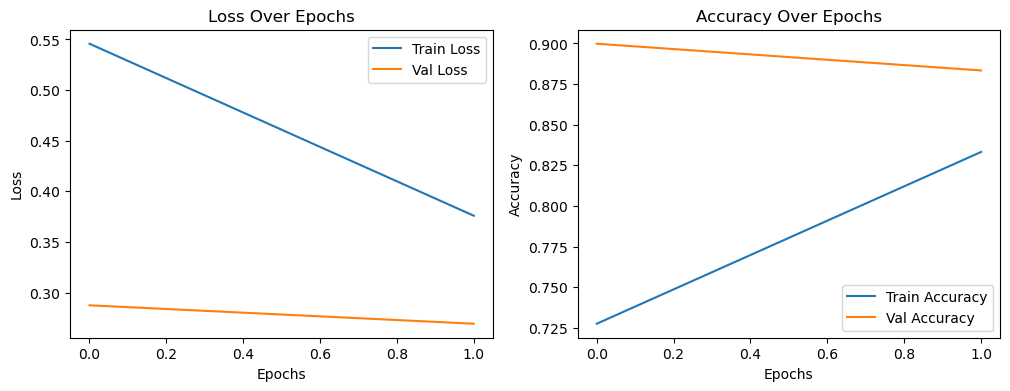

In [11]:
import matplotlib.pyplot as plt

# Plot loss and accuracy
def plot_history(history):
    plt.figure(figsize=(12,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.show()

# Call the function to plot training history
plot_history(history)


### Improve the Model with Transfer Learning

In [12]:
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential

### Function to Build a Transfer Learning Model

In [13]:
def build_transfer_learning_model(base_model):
    base_model.trainable = False  # Freeze the layers of the pre-trained model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # 1 neuron output with sigmoid for binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


### Choosing a Transfer Learning Model

In [14]:
# Select Model
resnet_model = build_transfer_learning_model(ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
densenet_model = build_transfer_learning_model(DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
efficientnet_model = build_transfer_learning_model(EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))

# Display model architecture
resnet_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Train the Transfer Learning Model

In [15]:
history_resnet = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2,
    callbacks=callbacks
)

Epoch 1/2
168/168 ━━━━━━━━━━━━━━━━━━━━ 449s 3s/step - accuracy: 0.4991 - loss: 0.7678 - val_accuracy: 0.4768 - val_loss: 0.6945 - learning_rate: 0.0010
Epoch 2/2
168/168 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.5203 - loss: 0.6940 - val_accuracy: 0.5232 - val_loss: 0.6919 - learning_rate: 0.0010


21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5378 - loss: 0.6913
ResNet50 accuracy on the test set: 52.24%


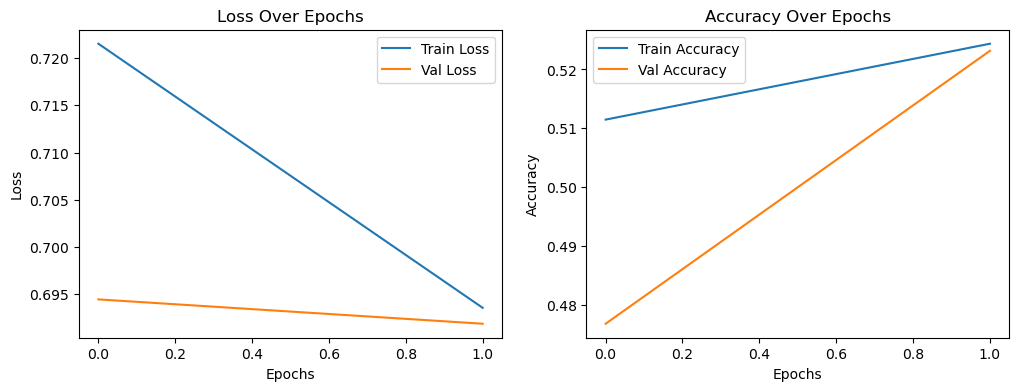

In [16]:
test_loss, test_acc = resnet_model.evaluate(test_generator)
print(f"ResNet50 accuracy on the test set: {test_acc*100:.2f}%")
plot_history(history_resnet)


### Fine-tuning to Optimize the Transfer Learning Model

#### Unfreeze the Model Layers

In [17]:
# Unfreeze the last 50% of layers
for layer in resnet_model.layers[0].layers[-50:]:
    layer.trainable = True  # Allow weight updates during fine-tuning

# Reduce the learning rate to prevent damaging the pre-trained weights
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                     loss="binary_crossentropy", 
                     metrics=["accuracy"])

# Check the trainable status of layers
for layer in resnet_model.layers[0].layers:
    print(layer.name, ":", "Trainable" if layer.trainable else "Frozen")


input_layer_1 : Frozen
conv1_pad : Frozen
conv1_conv : Frozen
conv1_bn : Frozen
conv1_relu : Frozen
pool1_pad : Frozen
pool1_pool : Frozen
conv2_block1_1_conv : Frozen
conv2_block1_1_bn : Frozen
conv2_block1_1_relu : Frozen
conv2_block1_2_conv : Frozen
conv2_block1_2_bn : Frozen
conv2_block1_2_relu : Frozen
conv2_block1_0_conv : Frozen
conv2_block1_3_conv : Frozen
conv2_block1_0_bn : Frozen
conv2_block1_3_bn : Frozen
conv2_block1_add : Frozen
conv2_block1_out : Frozen
conv2_block2_1_conv : Frozen
conv2_block2_1_bn : Frozen
conv2_block2_1_relu : Frozen
conv2_block2_2_conv : Frozen
conv2_block2_2_bn : Frozen
conv2_block2_2_relu : Frozen
conv2_block2_3_conv : Frozen
conv2_block2_3_bn : Frozen
conv2_block2_add : Frozen
conv2_block2_out : Frozen
conv2_block3_1_conv : Frozen
conv2_block3_1_bn : Frozen
conv2_block3_1_relu : Frozen
conv2_block3_2_conv : Frozen
conv2_block3_2_bn : Frozen
conv2_block3_2_relu : Frozen
conv2_block3_3_conv : Frozen
conv2_block3_3_bn : Frozen
conv2_block3_add : Froz

#### Retrain the Model (Fine-tuning)

In [18]:
history_finetune = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 638s 3s/step - accuracy: 0.6752 - loss: 0.5875 - val_accuracy: 0.5262 - val_loss: 0.7093 - learning_rate: 1.0000e-05
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.8262 - loss: 0.3870 - val_accuracy: 0.8550 - val_loss: 0.3457 - learning_rate: 1.0000e-05
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 582s 3s/step - accuracy: 0.8758 - loss: 0.3134 - val_accuracy: 0.9148 - val_loss: 0.2196 - learning_rate: 1.0000e-05
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 666s 4s/step - accuracy: 0.8765 - loss: 0.3130 - val_accuracy: 0.7713 - val_loss: 0.6188 - learning_rate: 1.0000e-05
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 648s 4s/step - accuracy: 0.8892 - loss: 0.2694 - val_accuracy: 0.5501 - val_loss: 1.1484 - learning_rate: 1.0000e-05
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 604s 4s/step - accuracy: 0.8932 - loss: 0.2633 - val_accuracy: 0.9387 - val_loss: 0.1754 - learning_rate: 1.0000e-05
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 598s 4s/step - acc

#### Evaluating the Fine-Tuned Model on the Test Set

21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9650 - loss: 0.1106
Accuracy of the Fine-Tuned model on the test set: 97.01%


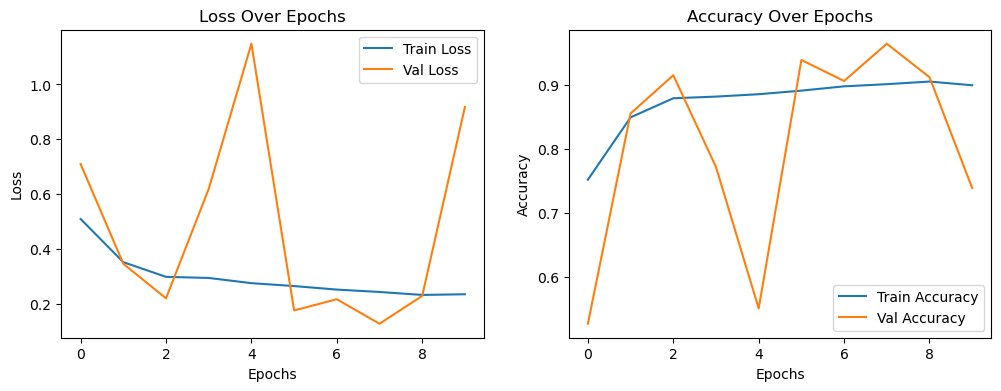

In [19]:
test_loss, test_acc = resnet_model.evaluate(test_generator)
print(f"Accuracy of the Fine-Tuned model on the test set: {test_acc*100:.2f}%")
plot_history(history_finetune)


In [ ]:

resnet_model.save("tuberculosis_classifier.h5")

Mô hình đã được lưu thành công!


In [21]:
resnet_model.save("my_model.keras")